# Data Generotor

- Task1: Select a portion of the large dataset with appropriate road ratio


- Task2: Transform data
    - Rotation etc
    - Split data into pieces

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import os
import cv2

In [2]:
# dilate & split setting
root_path = 'D://Data/massachusetts-roads-dataset/'
# root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'

road_class_type_path_from = 'tiff/'
road_class_type_path_to = 'tiff_select5/'
road_class_type_path_to_split = "tiff_select5_parts_16/"
road_path_from = root_path + road_class_type_path_from
road_path_to = root_path + road_class_type_path_to
road_path_to_split = root_path + road_class_type_path_to_split

In [3]:
# # split setting
# root_path = 'D://Data/massachusetts-roads-dataset/'
# # root_path = '/home/renyan/ossdata/massachusetts-roads-dataset/'

# road_class_type_path_from = 'tiff/'
# road_class_type_path_to = 'tiff_select3/'
# road_class_type_path_to_split = "tiff_select3_parts_16/"
# road_path_from = root_path + road_class_type_path_from
# road_path_to = root_path + road_class_type_path_to
# road_path_to_split = root_path + road_class_type_path_to_split

## Selection

In [4]:
# get all file paths
def get_file_subpaths(path, whole = True, sort = True):
    path_prefix = path if whole else ""
    subpaths = [path_prefix + file_name for file_name in list(os.walk(path))[0][2]]
    if sort:
        subpaths.sort()
    return subpaths

In [5]:
# For labels: Select pairs with high road ratio as EXCELLENT DATASET
def road_ratio(label):
    flat = label.flatten()
    flat = flat/255 if flat.max() > 1 else flat
    return flat.sum()/np.prod(label.shape)

# For images: Select pairs with little white ratio as GOOD DATASET
def valid_ratio(img):
    flat = img.flatten()/255 if img.max() > 1 else img.flatten()
    valid_ratio = np.sum(np.ceil(1-flat))/np.prod(img.shape)
    return valid_ratio

In [6]:
# plot selected image-label pair with valid_ratio and road_ratio
def plot_selection(idx, p_img, p_lbl, valid_ratios, road_ratios, limit = 0):
    if limit == 0:
        limit = len(idx)
    for i in idx[:limit]:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(cv2.imread(p_img[i]))
        plt.title(str(valid_ratios[i]))
        plt.subplot(1,2,2)
        plt.imshow(cv2.imread(p_lbl[i]))
        plt.title(str(road_ratios[i]))

In [7]:
# save files of old paths to new paths
# dilated_para: None for no dilation, [kernel, itr_num]
def save_copy_dilate(old_paths, new_paths, dilated_para = None):
    for i, (old_path, new_path) in enumerate(zip(old_paths, new_paths)):
        if dilated_para:
            kernel = np.ones((dilated_para[0], dilated_para[0]),np.uint8)
            t = cv2.dilate(cv2.imread(old_path), kernel, dilated_para[1])
        else:
            t = cv2.imread(old_path)
        cv2.imwrite(new_path, t)
    print("Copy {} files.!".format(len(new_paths)))

In [8]:
# make directory
def mkdir_level2(folder_path, sub_folder_names = None):
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path) 
        print(folder_path + " --- built!")
    if sub_folder_names:
        for sub_folder_name in sub_folder_names:
            if not os.path.isdir(folder_path + sub_folder_name + "/"):
                os.mkdir(folder_path + sub_folder_name + "/") 
        print("{} sub_folder done.".format(len(sub_folder_names)))

In [9]:
road_path_from + "train/"

'D://Data/massachusetts-roads-dataset/tiff/train/'

In [10]:
train_p_img = get_file_subpaths(road_path_from + "train/")
train_p_lbl = get_file_subpaths(road_path_from + "train_labels/")

In [11]:
valid_ratios = [valid_ratio(cv2.imread(t)) for t in tqdm(train_p_img)]

100%|██████████| 1108/1108 [01:59<00:00,  9.25it/s]


In [12]:
road_ratios = [road_ratio(cv2.imread(t)) for t in tqdm(train_p_lbl)]

100%|██████████| 1108/1108 [00:56<00:00, 19.63it/s]


In [13]:
# plt.hist(valid_ratios, bins = 20);

In [14]:
# plt.hist(road_ratios, bins = 20);

In [15]:
# valid_threshold = np.percentile(valid_ratios, 95)
valid_threshold = np.float64(0.8)
road_threshold = np.percentile(road_ratios, 20)
print(valid_threshold, road_threshold)

0.8 0.01800551111111111


In [16]:
valid_idx = np.where(valid_ratios >= valid_threshold)[0].tolist()
road_idx = np.where(road_ratios >= road_threshold)[0].tolist()
print(len(valid_idx), len(road_idx))

841 886


In [17]:
target_idx = list(set(valid_idx).intersection(set(road_idx)))
print("excel and valid ({}):\n {}".format(len(target_idx), target_idx[:10]))

excel and valid (707):
 [1, 2, 9, 10, 11, 13, 17, 18, 19, 20]


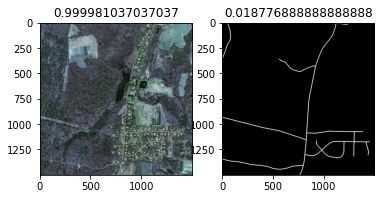

In [18]:
plot_selection(target_idx, train_p_img, train_p_lbl, valid_ratios, road_ratios, 1)

In [19]:
road_path_to

'D://Data/massachusetts-roads-dataset/tiff_select5/'

In [20]:
mkdir_level2(road_path_to, ["train", "train_labels", "val", "val_labels", "test", "test_labels"])

D://Data/massachusetts-roads-dataset/tiff_select5/ --- built!
6 sub_folder done.


In [21]:
# train image
old_paths = [train_p_img[i] for i in target_idx]
new_paths = [road_path_to + "train/" + file_name for file_name in [t.split("/")[-1] for t in old_paths]]
save_copy_dilate(old_paths, new_paths)

Copy 707 files.!


In [22]:
# tain label
old_paths = [train_p_lbl[i] for i in target_idx]
new_paths = [road_path_to + "train_labels/" + file_name for file_name in [t.split("/")[-1] for t in old_paths]]
save_copy_dilate(old_paths, new_paths, [5, 1])
# save_copy_dilate(old_paths, new_paths)

Copy 707 files.!


In [23]:
# val image
old_paths = get_file_subpaths(road_path_from + "val/")
new_paths = [road_path_to + "val/" + file_name for file_name in get_file_subpaths(road_path_from + "val/", whole = False)]
save_copy_dilate(old_paths, new_paths)
# val label
old_paths = get_file_subpaths(road_path_from + "/val_labels/")
new_paths = [road_path_to + "val_labels/" + file_name for file_name in get_file_subpaths(road_path_from + "val_labels/", whole = False)]
save_copy_dilate(old_paths, new_paths, [5, 1])
# save_copy_dilate(old_paths, new_paths)

Copy 14 files.!
Copy 14 files.!


In [24]:
# test image
old_paths = get_file_subpaths(road_path_from + "test/")
new_paths = [road_path_to + "test/" + file_name for file_name in get_file_subpaths(road_path_from + "test/", whole = False)]
save_copy_dilate(old_paths, new_paths)
# # test label
old_paths =  get_file_subpaths(road_path_from + "test_labels/")
new_paths = [road_path_to + "test_labels/" + file_name for file_name in  get_file_subpaths(road_path_from + "test_labels/", whole = False)]
save_copy_dilate(old_paths, new_paths)

Copy 49 files.!
Copy 49 files.!


## Split

In [25]:
# get left-top, left-bottom, right-top, right-bottom parts saved
# split images into n*n pieces
def save_split(old_paths, new_paths, n):
    height, width = cv2.imread(old_paths[0]).shape[0:2]
    h_unit, w_unit = height // n, width // n
    for i, (old_path, new_path) in enumerate(zip(old_paths, new_paths)):
        new_root, suffix = new_path.split(".")
        img = cv2.imread(old_path)
        for h, w in itertools.product(range(n), range(n)):
            cv2.imwrite("{}_h{}_w{}.{}".format(new_root, h+1, w+1, suffix),
                       img[h*h_unit:(h+1)*h_unit, w*w_unit:(w+1)*w_unit])
    print("Save split images")

In [26]:
mkdir_level2(road_path_to_split, ["train", "train_labels", "val", "val_labels", "test", "test_labels"])

D://Data/massachusetts-roads-dataset/tiff_select5_parts_16/ --- built!
6 sub_folder done.


In [27]:
# train image
old_paths = get_file_subpaths(road_path_to + "train/")
new_paths = [road_path_to_split + "train/" + file_name for file_name in get_file_subpaths(road_path_to + "train/", whole = False)]
save_split(old_paths, new_paths, 4)

Save split images


In [28]:
# train labels
old_paths = get_file_subpaths(road_path_to + "train_labels/")
new_paths = [road_path_to_split + "train_labels/" + file_name for file_name in get_file_subpaths(road_path_to + "train_labels/", whole = False)]
save_split(old_paths, new_paths, 4)

Save split images


In [29]:
# val image
old_paths = get_file_subpaths(road_path_to + "val/")
new_paths = [road_path_to_split + "val/" + file_name for file_name in get_file_subpaths(road_path_to + "val/", whole = False)]
save_split(old_paths, new_paths, 4)
# val label
old_paths = get_file_subpaths(road_path_to + "val_labels/")
new_paths = [road_path_to_split + "val_labels/" + file_name for file_name in get_file_subpaths(road_path_to + "val_labels/", whole = False)]
save_split(old_paths, new_paths, 4)

Save split images
Save split images


In [30]:
# test image
old_paths = get_file_subpaths(road_path_to + "test/")
new_paths = [road_path_to_split + "test/" + file_name for file_name in get_file_subpaths(road_path_to + "test/", whole = False)]
save_split(old_paths, new_paths, 4)
# test label
old_paths = get_file_subpaths(road_path_to + "test_labels/")
new_paths = [road_path_to_split + "test_labels/" + file_name for file_name in get_file_subpaths(road_path_to + "test_labels/", whole = False)]
save_split(old_paths, new_paths, 4)

Save split images
Save split images


## Remove Incompetent Data

In [31]:
split_paths_img = get_file_subpaths(road_path_to_split + "train/")
split_paths_lbl = get_file_subpaths(road_path_to_split + "train_labels/")

In [32]:
road_ratios = [road_ratio(cv2.imread(lbl)) for lbl in split_paths_lbl]

In [33]:
valid_ratios = [valid_ratio(cv2.imread(img)) for img in split_paths_img]

In [34]:
valid_threshold = np.float64(0.95)
road_threshold = np.percentile(road_ratios, 20)

not_valid_idx = np.where(valid_ratios < valid_threshold)[0].tolist()
not_road_idx = np.where(road_ratios < road_threshold)[0].tolist()

In [35]:
not_target_idx = list(set(not_valid_idx).union(set(not_road_idx)))
not_target_idx.sort()

In [36]:
len(not_target_idx)

2476

In [37]:
delete_paths_img = [split_paths_img[i] for i in not_target_idx]
delete_img = [t.split("/")[-1].split(".")[0] for t in delete_paths_img]
delete_paths_lbl = [split_paths_lbl[i] for i in not_target_idx]
delete_lbl = [t.split("/")[-1].split(".")[0] for t in delete_paths_lbl]

In [38]:
for t in delete_paths_lbl:
    os.remove(t)

In [39]:
for t in delete_paths_img:
    os.remove(t)